In [1]:
newContext=False

In [2]:
if newContext:
    # Set the new configuration
    print("Loading new Spark configuration")
    conf = SparkConf().setAll([('spark.executor.memory', '8g'),\
                               ('spark.driver.memory', '6g'),\
                               ('spark.shuffle.service.enabled', True), \
                               ('spark.sql.shuffle.partitions', 144), \
                               ('spark.default.parallelism', 144),\
                               ('spark.dynamicAllocation.enabled', True), \
                               ('spark.dynamicAllocation.executorIdleTimeout', 600), \
                               ('spark.executor.cores', 4),\
                               ('spark.executor.instances', 25), \
                               ('spark.local.dir','/mnt/FITs/Spark/tmp'),\
                               ('spark.executor.memoryOverhead', '6g'),\
                               ('spark.driver.memoryOverhead', '4g'),\
                               ('spark.rpc.message.maxSize', '512'),\
                               ('spark.scheduler.mode', 'FAIR'),\
                               ('spark.kryoserializer.buffer.max', '1g'),\
                               ('spark.hadoop.hive.exec.dynamic.partition', True), \
                               ('spark.hadoop.hive.exec.dynamic.partition.mode','nonstrict'), \
                               ('spark.hadoop.hive.exec.max.dynamic.partitions', 100000), \
                               ('spark.hadoop.hive.exec.max.dynamic.partitions.pernode', 100000), \
                               ('spark.app.name','Creating FITs dimensions')])

    # Stop the old context
    sc.stop()

    # And restart the context with the new configuration
    sc = SparkContext(conf=conf)
    sqlContext = SQLContext(sc)
    newContext=True

In [3]:
sc

<SparkContext master=yarn appName=pyspark-shell>

In [4]:
spark

In [5]:
sqlContext

## Import the necessary libraries

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import astropy_mpl_style
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
plt.style.use(astropy_mpl_style)

import numpy as np
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats

from scipy import sparse
from scipy.sparse import csr_matrix

from random import randint
from time import sleep

from spectral_cube import SpectralCube
from astroquery.esasky import ESASky
from astroquery.utils import TableList
from reproject import reproject_interp
import astropy.units as u

from pyspark.sql import SQLContext, SparkSession
from pyspark import StorageLevel

from pyspark import SparkFiles

from pyspark.sql import functions as F
import pyspark.sql.functions as f

from pyspark.sql.functions import randn, monotonically_increasing_id, row_number, desc, udf, col, lit
from pyspark.sql.functions import broadcast
from pyspark.sql.types import ArrayType, FloatType,IntegerType, DataType, DoubleType,Row, BooleanType

"""
Set the Spark datatypes
"""
iType=IntegerType()
dType=DoubleType()
fType=FloatType()

from pyspark.sql.functions import pandas_udf, PandasUDFType

from pyspark.sql.window import Window

from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import SparseVector, DenseVector,VectorUDT

from datetime import datetime

maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/cache


## Class definitions

In [7]:
from time import time, clock
class Timer:
    """
    a simple class for printing time (s) since last call
    """
    def __init__(self):
        self.t0=time()
        self.t1=clock()
        self.elapsed = 1
        self.elapsedCPU = 1
    
    def start(self):
        self.t0=time()
        self.t1=clock()
        
    def stop(self):
        t1=time()
        t2=clock()
        print("Elapsed {:2.1f}s, CPU {:2.1f}s".format(t1-self.t0, t2-self.t1))
        self.elapsed = t1-self.t0
        self.elapsedCPU = t2-self.t1

timer=Timer()

## Function and UDF definitions

### Functions

In [8]:
def reshape_image(im):
    """
    By default, Spark shapes images into (nx, 1, ny).
    This routine reshapes images into (nx, ny)

    Parameters
    ----------
    im : 3D array
        Original image with shape (nx, 1, ny)

    Returns
    ----------
    im_reshaped : 2D array
        Original image with shape (nx, ny)
        
    """
    shape = np.array(np.shape(im))
    shape=np.delete(shape, np.where(shape==1))
    return im.reshape(shape)
    #return im.reshape((shape[0], shape[2]))    return im.reshape((shape[0], shape[2]))
    
def rowdf_into_imageRDD_with_zipIdx(df):
    return df.rdd.zipWithIndex()
    
def rowdf_into_imagerdd(df, final_num_partition=1):
    """
    Reshape a DataFrame of rows into a RDD containing the full image
    in one partition.

    Parameters
    ----------
    df : DataFrame
        DataFrame of image rows.
    final_num_partition : Int
        The final number of partitions. Must be one (default) unless you
        know what you are doing.

    Returns
    ----------
    imageRDD : RDD
        RDD containing the full image in one partition
        
    return df.rdd.zipWithIndex().coalesce(final_num_partition).glom()
    
    """

    return df.rdd.coalesce(final_num_partition).glom()
    
def get_stat(data, sigma=3.0, iters=3):
    """
    Estimate the background and background noise using
    sigma-clipped statistics.

    Parameters
    ----------
    data : 2D array
        2d array containing the data.
    sigma : float
        sigma.
    iters : int
        Number of iteration to perform to get accurate estimate.
        The higher the better, but it will be longer.
    """
    mean, median, std = sigma_clipped_stats(data, sigma=sigma, maxiters=iters)
    return mean, median, std


In [9]:
def GetDetailArrays(fitsFilename, raType, decType, spectraType):
    sqlStmt=("""
        select sda_detail_array, sda_detail_type
        from Sparkfits_detail_arrays
        where sda_filename='{}'
    """).format(fitsFilename)

    detailsDF=sqlContext.sql(sqlStmt)
    
    raArray=np.array(detailsDF.filter(f.col("sda_detail_type") == raType)\
                     .select(f.col("sda_detail_array")).collect() )
    raArray=raArray.reshape(raArray.shape[2])

    decArray=np.array(detailsDF.filter(f.col("sda_detail_type") == decType)\
                      .select(f.col("sda_detail_array")).collect() )
    decArray=decArray.reshape(decArray.shape[2])

    spectraArray=np.array(detailsDF.filter(f.col("sda_detail_type") == spectraType)\
                          .select(f.col("sda_detail_array")).collect() )
    spectraArray=spectraArray.reshape(spectraArray.shape[2])

    return raArray, decArray, spectraArray

In [10]:
## Nice utilities from Joe Filippazzo
## http://www.bdnyc.org/2012/10/decimal-deg-to-hms/

def deg2HMS(ra='', dec='', round=False):
  RA, DEC, rs, ds = '', '', '', ''
  if dec:
    if str(dec)[0] == '-':
      ds, dec = '-', abs(dec)
    deg = int(dec)
    decM = abs(int((dec-deg)*60))
    if round:
      decS = int((abs((dec-deg)*60)-decM)*60)
    else:
      decS = (abs((dec-deg)*60)-decM)*60
    DEC = '{0}{1} {2} {3}'.format(ds, deg, decM, decS)
  
  if ra:
    if str(ra)[0] == '-':
      rs, ra = '-', abs(ra)
    raH = int(ra/15)
    raM = int(((ra/15)-raH)*60)
    if round:
      raS = int(((((ra/15)-raH)*60)-raM)*60)
    else:
      raS = ((((ra/15)-raH)*60)-raM)*60
    RA = '{0}{1} {2} {3}'.format(rs, raH, raM, raS)
  
  if ra and dec:
    return (RA, DEC)
  else:
    return RA or DEC

def HMS2deg(ra='', dec=''):
  RA, DEC, rs, ds = '', '', 1, 1
  if dec:
    D, M, S = [float(i) for i in dec.split()]
    if str(D)[0] == '-':
      ds, D = -1, abs(D)
    deg = D + (M/60) + (S/3600)
    DEC = '{0}'.format(deg*ds)
  
  if ra:
    H, M, S = [float(i) for i in ra.split()]
    if str(H)[0] == '-':
      rs, H = -1, abs(H)
    deg = (H*15) + (M/4) + (S/240)
    RA = '{0}'.format(deg*rs)
  
  if ra and dec:
    return (RA, DEC)
  else:
    return RA or DEC

In [11]:
"""

Functions used with UDFs

"""

def calculateBand(x, bandCount):
    x = x // bandCount
    return x


def CastStructToArray(StructCol):
    imageArray = np.asarray(StructCol[0]).tolist()
    return imageArray

def dummyReturn(x):
    return x.tolist()

def returnAsIs(x):
    return x


### UDF Wrapper functions

In [12]:
GetBandUDF = udf(lambda arr, bw: calculateBand(np.int(arr), bw), iType)
CastToInt = udf(lambda x: dummyReturn(x), iType)
CastToFloatArrayUDF = udf(lambda x : CastStructToArray(x), ArrayType(fType))
CastToIntArrayUDF = udf(lambda x : CastStructToArray(x), ArrayType(iType))
castToFloat = udf(lambda arr: returnAsIs(arr), fType)

## Set up the connection to Hive on HDFS

Set default databas to fits_investigation

Show databases tables

In [13]:
sqlContext.sql("show databases").show()
sqlContext.sql("use fits_investigation")
sqlContext.sql("show tables").show()


+------------------+
|      databaseName|
+------------------+
|           default|
|fits_investigation|
|          plasticc|
+------------------+

+------------------+--------------------+-----------+
|          database|           tableName|isTemporary|
+------------------+--------------------+-----------+
|fits_investigation|          array_test|      false|
|fits_investigation|declimation_dim_temp|      false|
|fits_investigation|    fits_header_data|      false|
|fits_investigation|          float_test|      false|
|fits_investigation|  imagetestsparkfits|      false|
|fits_investigation|   localparalleltest|      false|
|fits_investigation|localparalleltest...|      false|
|fits_investigation|localparalleltest...|      false|
|fits_investigation|localparalleltest...|      false|
|fits_investigation|  newdfdeletemelater|      false|
|fits_investigation|     parquetdataview|      false|
|fits_investigation|parquetpartitione...|      false|
|fits_investigation|parquetpartitione...| 

## Data extraction

### Get the files we have loaded into Parquet

In [14]:
filesDF=sqlContext.sql("""
    show partitions sparkfits_detail_arrays
""")
filesDF.show(80, False)

+---------------------------------------------------------------------------------------+
|partition                                                                              |
+---------------------------------------------------------------------------------------+
|sda_filename=ASKAPsim_pol1.image.I.restored.fits/sda_detail_type=DEC--SIN              |
|sda_filename=ASKAPsim_pol1.image.I.restored.fits/sda_detail_type=GHz                   |
|sda_filename=ASKAPsim_pol1.image.I.restored.fits/sda_detail_type=Hz                    |
|sda_filename=ASKAPsim_pol1.image.I.restored.fits/sda_detail_type=RA---SIN              |
|sda_filename=ASKAPsim_pol1.image.I.restored.fits/sda_detail_type=km s-1                |
|sda_filename=ASKAPsim_pol1.image.Q.restored.fits/sda_detail_type=DEC--SIN              |
|sda_filename=ASKAPsim_pol1.image.Q.restored.fits/sda_detail_type=GHz                   |
|sda_filename=ASKAPsim_pol1.image.Q.restored.fits/sda_detail_type=Hz                    |
|sda_filen

## Set selection variables

In [15]:
#fitsFilename='residual.i.SB8170.cube.fits.NaNs.Removed'
fitsFilename='image.restored.i.SB2338.V2.cube.fits'
raType='RA---SIN'
decType='DEC--SIN'
spectraType='Hz'

# Pull an image from Parquet

#### Get the header

In [16]:
def RetrieveHeader(df):
    # Create header file

    hdu=fits.PrimaryHDU()
    hduHeader=hdu.header

    def isFloat(string):
        try:
            float(string)
            return True
        except ValueError:
            return False
    for row in hduData.rdd.toLocalIterator():

        if row.sfh_value=='True':
            v=True
        elif isFloat(row.sfh_value):
            v=float(row.sfh_value)
            pass
        elif row.sfh_value.isnumeric():
            v=int(row.sfh_value)
            pass
        else:
            v=row.sfh_value
        #print(row.key, v) #row.value, row.value.isnumeric(), isFloat(row.value), bool(row.value))
        hduHeader[row.sfh_key] = (v, row.sfh_comment)
        pass
    
    return hduHeader

#### Get the data cards from Parquet

In [17]:
fitsFilename

'image.restored.i.SB2338.V2.cube.fits'

In [18]:
sqlContext.sql("desc fits_investigation.sparkfits_fits_headers ").show()

+--------------------+---------+-------+
|            col_name|data_type|comment|
+--------------------+---------+-------+
|           sfh_index|   bigint|   null|
|             sfh_key|   string|   null|
|           sfh_value|   string|   null|
|         sfh_comment|   string|   null|
|       sfh_fits_file|   string|   null|
|# Partition Infor...|         |       |
|          # col_name|data_type|comment|
|       sfh_fits_file|   string|   null|
+--------------------+---------+-------+



In [19]:
sqlStmt=("""select * from sparkfits_fits_headers 
where sfh_fits_file='{}' 
order by sfh_index""".format(fitsFilename))

hduData=sqlContext.sql(sqlStmt)
hduData.show()

+---------+-------+---------------+--------------------+--------------------+
|sfh_index|sfh_key|      sfh_value|         sfh_comment|       sfh_fits_file|
+---------+-------+---------------+--------------------+--------------------+
|        0| SIMPLE|           True|       Standard FITS|image.restored.i....|
|        1| BITPIX|            -32|Floating point (3...|image.restored.i....|
|        2|  NAXIS|              4|                    |image.restored.i....|
|        3| NAXIS1|           5607|                    |image.restored.i....|
|        4| NAXIS2|           5654|                    |image.restored.i....|
|        5| NAXIS3|              1|                    |image.restored.i....|
|        6| NAXIS4|           2592|                    |image.restored.i....|
|        7| BSCALE|            1.0|PHYSICAL = PIXEL*...|image.restored.i....|
|        8|  BZERO|            0.0|                    |image.restored.i....|
|       10|  BUNIT|        Jy/beam|Brightness (pixel...|image.re

#### Extract the data cards and recreate the header

In [20]:
retrievedHeader = RetrieveHeader(hduData)


In [21]:
myWcs=WCS(retrievedHeader)
retrievedHeader

SIMPLE  =                    T / Standard FITS                                  
BITPIX  =                -32.0 / Floating point (32 bit)                        
NAXIS   =                  4.0                                                  
EXTEND  =                    T                                                  
NAXIS1  =               5607.0                                                  
NAXIS2  =               5654.0                                                  
NAXIS3  =                  1.0                                                  
NAXIS4  =               2592.0                                                  
BSCALE  =                  1.0 / PHYSICAL = PIXEL*BSCALE + BZERO                
BZERO   =                  0.0                                                  
BUNIT   = 'Jy/beam '           / Brightness (pixel) unit                        
EQUINOX =               2000.0                                                  
RADESYS = 'FK5     '        

In [22]:
myWcs

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 332.6475708333  -44.83073888889  1.0  1376500000.056  
CRPIX : 3175.0  3252.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.001111111111111  0.001111111111111  1.0  18518.51799989  
NAXIS : 5607.0  5654.0  1.0  2592.0

### Extracting a sub cube

In [23]:
fitsFilename, raType, decType, spectraType

('image.restored.i.SB2338.V2.cube.fits', 'RA---SIN', 'DEC--SIN', 'Hz')

In [24]:
raArray, decArray, spectraArray = GetDetailArrays(fitsFilename, raType, decType, spectraType)

In [25]:
print("Range of Ra {} to {}".format( max(raArray), min(raArray)))
print("Range of Declination {} to {}".format( max(decArray), min(decArray)))
print("Frequency ranges in {} - {} {}".format(spectraType, min(spectraArray), max(spectraArray))) 

Range of Ra 337.9596862792969 to 328.57586669921875
Range of Declination -42.05752944946289 to -48.32979202270508
Frequency ranges in Hz - 1376499968.0 1424481536.0


In [26]:
print("Range of Ra in hh:mm:ss {} to {}".format( deg2HMS(ra=max(raArray)), deg2HMS(ra=min(raArray))  ))


Range of Ra in hh:mm:ss 22 31 50.324707031244884 to 21 54 18.208007812501705


In [27]:
print("Required range of Ra in degrees - {} to {}".format( HMS2deg(ra='22 05 31.000'), HMS2deg(ra='22 09 47.000')))  

Required range of Ra in degrees - 331.37916666666666 to 332.4458333333333


Declination range we want is -42.7 to -43.8

Lets take 7 channels from Channel 14

In [ ]:
spectraArray[14], spectraArray[20]

In [28]:
hiDec=-46.7
loDec=-47.2
hiRa=332.4
loRa=331.4
loFreq=spectraArray[7]
hiFreq=spectraArray[9]

CubeSize=[hiRa,loRa,hiDec,loDec,loFreq,hiFreq]

The CubeSize array contains the dimension size we want

In [29]:
CubeSize

[332.4, 331.4, -46.7, -47.2, 1376629632.0, 1376666624.0]

In [30]:
fitsFilename, decType,spectraType

('image.restored.i.SB2338.V2.cube.fits', 'DEC--SIN', 'Hz')

## Heres the functions to get the cube

As per the SubCubeFITS notebook, we demonstrate two methods

### METHOD 1

Using Spark dataframes. Using the dataframes we have already created, we'll filter these dataframes for the data we require. Also, notice that when we are creating the actual sub cube dataframe, we're using broadcast joins on the smaller dimensional dataframes.

In [31]:
def GetSubCube(fitsFilename, decType,spectraType, raArray, decArray, spectraArray, CubeSize):
    timer.start()
    ## Extract our parameters
    hiRa=CubeSize[0]
    loRa=CubeSize[1]
    hiDec=CubeSize[2]
    loDec=CubeSize[3]
    loFreq=CubeSize[4]
    hiFreq=CubeSize[5]
    
    def CreateNewHeader():
        return True
    
    raSelectRange=np.where(np.logical_and(raArray >= loRa, raArray <= hiRa ))
    raSelectList=raSelectRange[0].tolist()
    
    raHeaderIndex=raArray[raSelectList[0]]
    naxis1=len(raSelectList)
    
    decDF=sqlContext.sql("""
    with data as 
    (
        select posexplode(sda_detail_array)
        from sparkfits_detail_arrays
        where sda_filename='image.restored.i.SB2338.V2.cube.fits'
        and sda_detail_type='{}'
    )
    select pos as sda_index, float(col) as sda_declination from data

    """.format(decType)      )
    
    freqDF=sqlContext.sql("""
    with data as 
    (
        select posexplode(sda_detail_array)
        from sparkfits_detail_arrays
        where sda_filename='image.restored.i.SB2338.V2.cube.fits'
        and sda_detail_type='{}'
    )
    select pos as sda_index, float(col) as sda_Frequency_hz from data

    """.format(spectraType)      )
    
    #decDF.registerTempTable("DECLINATIONS")
    #freqDF.registerTempTable("FREQUENCIES")
    
    myImageDF=sqlContext.sql("select * from sparkfits_images where spi_filename='{}' ".format(fitsFilename))
    #myImageDF.registerTempTable("IMAGES")
    
    decFilterDF   = decDF.filter((decDF.sda_declination <= hiDec ) & (decDF.sda_declination >= loDec ))
    freqFilterDF  = freqDF.filter((freqDF.sda_Frequency_hz <= hiFreq ) \
                              & (freqDF.sda_Frequency_hz >= loFreq ))
    
    decHeaderIndex=decFilterDF.groupby().max('sda_declination').collect()[0].asDict()['max(sda_declination)']
    freqHeaderIndex=freqFilterDF.groupby().min('sda_Frequency_hz').collect()[0].asDict()['min(sda_Frequency_hz)']
    naxis2=decFilterDF.count()
    naxis4=freqFilterDF.count()
    
    
    subCubeDF=myImageDF.join(broadcast(freqFilterDF), myImageDF.spi_band == freqFilterDF.sda_index)\
    .join(broadcast(decFilterDF), myImageDF.spi_index == decFilterDF.sda_index)\
    .withColumn("raSelectRange", f.array([f.col("spi_image")[i] for i in raSelectList  ] ))\
    .select("spi_index","raSelectRange","spi_filename","spi_band").persist()
    
    print("Image dataframe created")
    timer.stop()
    
    return subCubeDF,raHeaderIndex,decHeaderIndex,freqHeaderIndex, naxis1,naxis2, naxis4
   

### METHOD 2

Using Spark and Hive SQL. We use the posexplode dataframes instantiated as temporary tables. Using these dataframes  we'll filter these dataframes for the data we require. Also, notice that when we are creating the actual sub cube dataframe, we're using broadcast joins on the smaller dimensional dataframes.

In [32]:
def GetSubCube2(fitsFilename, decType,spectraType, raArray, decArray, spectraArray, CubeSize):
    timer.start()
    ## Extract our parameters
    hiRa=CubeSize[0]
    loRa=CubeSize[1]
    hiDec=CubeSize[2]
    loDec=CubeSize[3]
    loFreq=CubeSize[4]
    hiFreq=CubeSize[5]
    
    def CreateNewHeader():
        return True
    
    raSelectRange=np.where(np.logical_and(raArray >= loRa, raArray <= hiRa ))
    raSelectList=raSelectRange[0].tolist()
    
    raHeaderIndex=raArray[raSelectList[0]]
    naxis1=len(raSelectList)
    
    decDF=sqlContext.sql("""
    with data as 
    (
        select posexplode(sda_detail_array)
        from sparkfits_detail_arrays
        where sda_filename='image.restored.i.SB2338.V2.cube.fits'
        and sda_detail_type='{}'
    )
    select pos as sda_index, float(col) as sda_declination from data

    """.format(decType)      )
    
    freqDF=sqlContext.sql("""
    with data as 
    (
        select posexplode(sda_detail_array)
        from sparkfits_detail_arrays
        where sda_filename='image.restored.i.SB2338.V2.cube.fits'
        and sda_detail_type='{}'
    )
    select pos as sda_index, float(col) as sda_Frequency_hz from data

    """.format(spectraType)      )
    
    decDF.registerTempTable("DECLINATIONS")
    freqDF.registerTempTable("FREQUENCIES")

    decHeaderIndex=decFilterDF.groupby().max('sda_declination').collect()[0].asDict()['max(sda_declination)']
    freqHeaderIndex=freqFilterDF.groupby().min('sda_Frequency_hz').collect()[0].asDict()['min(sda_Frequency_hz)']
    naxis2=decFilterDF.count()
    naxis4=freqFilterDF.count()
    
    myImageDF=sqlContext.sql("select * from sparkfits_images where spi_filename='{}' ".format(fitsFilename))
    myImageDF.registerTempTable("IMAGES")

    subCubeSQLDF=sqlContext.sql("""
    select /*+ BROADCAST(DECLINATIONS), BROADCAST(FREQUENCIES) */
    spi_index, spi_image, spi_filename,spi_band
    from IMAGES
        INNER JOIN FREQUENCIES
            on IMAGES.spi_band == FREQUENCIES.sda_index
        INNER JOIN DECLINATIONS
            on IMAGES.spi_index == DECLINATIONS.sda_index

        WHERE FREQUENCIES.sda_Frequency_hz <= {}
            AND FREQUENCIES.sda_Frequency_hz >= {}
        AND DECLINATIONS.sda_declination <= -44 
            AND DECLINATIONS.sda_declination >= -44.5

        ORDER BY spi_band, spi_index
    """.format(hiFreq, loFreq, hiDec, loDec) )#.explain()
    
    # We still have to apply the Ra selectin criteria
    
    subCubeSQLDF=subCubeSQLDF\
    .withColumn("raSelectRange", f.array([f.col("spi_image")[i] for i in raSelectList  ] ))\
    .select("spi_index","raSelectRange","spi_filename","spi_band")
    
    print("Image dataframe created")
    
    timer.stop()
    
    return subCubeSQLDF,raHeaderIndex,decHeaderIndex,freqHeaderIndex, naxis1,naxis2, naxis4

### The function to create the new header.

In [33]:
def CreateNewHeader(df,ParentHeader,raHeaderIndex,decHeaderIndex,freqHeaderIndex, naxis1,naxis2, naxis4):
    timer.start()
    
    def isFloat(string):
        try:
            float(string)
            return True
        except ValueError:
            return False 
        
    #data=np.array(df.select(col('raSelectRange')).collect())
    # Take is quicker
    
    data=np.array(subCubeDF.select(col('raSelectRange')).take(naxis2*naxis4) )
    data=data.reshape(data.shape[0], data.shape[2])
    data=data.reshape(naxis4,naxis2,naxis1)
    data=data.reshape(naxis4,1,naxis2,naxis1)
    timer.stop()
    print(data.shape)
    timer.start()
    newhdu=fits.PrimaryHDU(data=data)
    newheader=newhdu.header
    print(newheader)
    
    for i in np.arange(len(ParentHeader)):
        try:
            newheader[list(ParentHeader.keys())[i]]
            # print("Exists!", list(jheader.keys())[i], jheader[int(i)],  jheader.comments[int(i)])
        except Exception as e:
            # print(list(header.keys())[i], header[int(i)],  header.comments[int(i)])
            jkey = list(ParentHeader.keys())[i]

            if isFloat(retrievedHeader[int(i)]):
                jval=float(ParentHeader[int(i)])
                pass
            elif ParentHeader[int(i)].isnumeric():
                jval=int(row.value)
                pass
            else:
                jval = ParentHeader[int(i)]


            jcom = ParentHeader.comments[int(i)]

            newheader[jkey] = (jval, jcom)
            
    wcs=WCS(ParentHeader)
    crpix1,crpix2,crpix3,crpix4=wcs.wcs_world2pix(raHeaderIndex,decHeaderIndex ,1, freqHeaderIndex,1, ra_dec_order=True)
    
    newheader['CRPIX1']=float(crpix1)
    newheader['CRPIX2']=float(crpix2)
    newheader['CRPIX3']=float(crpix3)
    newheader['CRPIX4']=float(crpix4)
    
    newWCS=WCS(newheader)

    print(newheader)
    timer.stop()
    return newheader, newWCS, data

In [34]:
subCubeDF,raHeaderIndex,decHeaderIndex,freqHeaderIndex,naxis1, naxis2, naxis4 \
=GetSubCube(fitsFilename, decType,spectraType, raArray, decArray, spectraArray, CubeSize)

Image dataframe created
Elapsed 29.8s, CPU 0.4s


In [35]:
subCubeDF.show()

+---------+--------------------+--------------------+--------+
|spi_index|       raSelectRange|        spi_filename|spi_band|
+---------+--------------------+--------------------+--------+
|     4185|[0.004352925, 0.0...|image.restored.i....|       8|
|     4186|[0.004102701, 0.0...|image.restored.i....|       8|
|     4187|[0.0036222248, 0....|image.restored.i....|       8|
|     4188|[0.0027488025, -1...|image.restored.i....|       8|
|     4189|[0.0015700328, -0...|image.restored.i....|       8|
|     4190|[4.2569492E-4, -0...|image.restored.i....|       8|
|     4191|[-2.1055761E-4, -...|image.restored.i....|       8|
|     4192|[8.076217E-5, -0....|image.restored.i....|       8|
|     4193|[0.0014862126, -3...|image.restored.i....|       8|
|     4194|[0.0038615824, 0....|image.restored.i....|       8|
|     4195|[0.006753172, 0.0...|image.restored.i....|       8|
|     4196|[0.009534607, 0.0...|image.restored.i....|       8|
|     4197|[0.01161725, 0.00...|image.restored.i....|  

If we create a temporary table from the sub cube dataframe, we can query it

In [36]:
subCubeDF.registerTempTable("SUBCUBE")

In [37]:
sqlContext.sql("select distinct spi_band from SUBCUBE").show()

+--------+
|spi_band|
+--------+
|       9|
|       8|
|       7|
+--------+



Using the temporary table, we can create an image on one slice of the sub cube

In [ ]:
data=np.array(sqlContext.sql("select raSelectRange from SUBCUBE where spi_band=17 order by spi_index ").collect() )

Or, we can create a new header, wcs object and data array for the subcube

In [38]:
newHeader, newWCS, data=\
CreateNewHeader(subCubeDF,retrievedHeader,raHeaderIndex,decHeaderIndex,freqHeaderIndex, naxis1,naxis2, naxis4)

Elapsed 1.0s, CPU 0.1s
(3, 1, 451, 597)
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    4 / number of array dimensions                     NAXIS1  =                  597                                                  NAXIS2  =                  451                                                  NAXIS3  =                    1                                                  NAXIS4  =                    3                                                  EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                                             

In [39]:
data.shape

(3, 1, 451, 597)

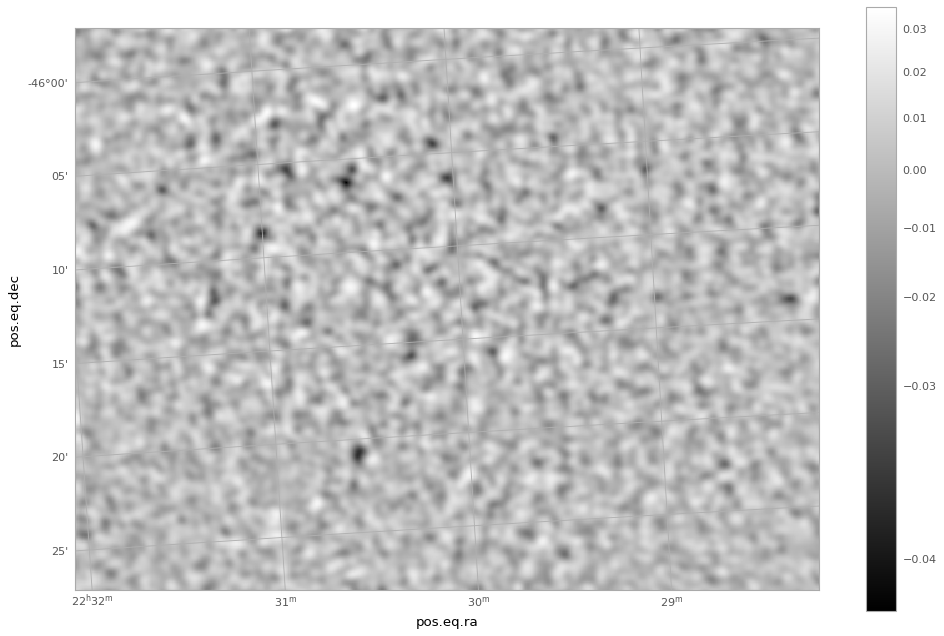

In [44]:
from astropy.utils.data import download_file
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(15,10), dpi= 80)
plt.subplot(projection=newWCS, slices=('x', 'y', 0,0))
plt.imshow(data[1,0,:,:], cmap='gray', norm=norm)
plt.colorbar()

In [43]:
CubeSize

[332.4, 331.4, -46.7, -47.2, 1376629632.0, 1376666624.0]